<h2><center>COMS7047A Term Project: Swahili News Classification</center></h2> 
<h2><center>Notebook 3 - Investigating Transformers</center></h2> 

<img src="./wits_logo.png" alt="Wits_Logo" style="width: 200px;"/>

***
<h4><center> Samantha Ball  &nbsp;   1603701   &nbsp;  2021</center></h4>

In this notebook, the use of deep learning techniques will be explored for the classification of Swahili news articles.

### Table of Contents

- Deep learning pipeline
- Preparing training, validation and test sets
- Model Instantiation and Training: Multilingual BERT
- Evaluation of classification performance 
- Model optimization: One cycle learning rate schedule, no. of epochs and class weights
- Final evaluation and discussion

Please note it is recommended to run this notebook in Google Colab due to GPU usage.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Swahili_News_Classification/

/content/drive/MyDrive/Swahili_News_Classification


## Transformers

The Transformer model is based on the concept of sequence-to-sequence models together with attention mechanisms. Transformer-based methods first pre-train the network on textual data to extract semantic knowledge which then forms the base for a variety of NLP tasks, rather than one specific task. 

### Deep learning pipeline

- The *ktrain* library will be utilised for the training and testing of each transformer model.
- The *huggingface* library will be utilised to provide pretrained transformer models which will then be fine-tuned on our Swahili News Classification dataset.

In [ ]:
# must check tensorflow version 2.0 or more recent is installed
import tensorflow as tf
print(tf.__version__)

2.5.0


#### Install ktrain library

In [3]:
# install ktrain
!pip3 install ktrain

     |████████████████████████████████| 25.3MB 119kB/s 
     |████████████████████████████████| 6.8MB 35.9MB/s 
     |████████████████████████████████| 983kB 47.6MB/s 
     |████████████████████████████████| 266kB 53.3MB/s 
     |████████████████████████████████| 1.9MB 46.9MB/s 
     |████████████████████████████████| 1.2MB 27.1MB/s 
     |████████████████████████████████| 471kB 47.2MB/s 
     |████████████████████████████████| 901kB 40.4MB/s 
     |████████████████████████████████| 3.3MB 42.2MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.3-cp37-none-any.whl size=25282390 sha256=0749d6f7c475cc561b25a0f581cb84a2bfca8280b195531419e1da81d61404c8
  Stored in directory: /root/.cache/pip/wheels/16/05/be/d6e659b3349016b1059e19fa028f165af4eeae2c196f329112
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=6af2019fa7d017cc533319598be1dd85209bac9c056b26d34211a9b35af7dea7
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7d

In [2]:
#----INSTALL LIBRARIES----#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
from sklearn.metrics import r2_score , mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split 
import ktrain
from ktrain import text
%matplotlib inline

### Train, validation and test sets

The dataset was split into a training, validation and test set with ratios 70%, 15% and 15% respectively.

In [5]:
#----IMPORT DATA----#
data_path = "./train.csv" # data given in CSV format
df = pd.read_csv(data_path) #read in data

pd.set_option('display.max_columns', None) #show all columns
print("The first 10 rows of the dataframe") 
df.head(10)

The first 10 rows of the dataframe


,id,content,category
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa
5,SW30734,MAJADILIANO kati ya aliyekuwa Mkurugenzi wa z...,kitaifa
6,SW28096,Mwandishi\nWetu – butiama MKUU wa majeshi\nmst...,kitaifa
7,SW1223,['Huenda Manchester United ikasubiri ukaguzi w...,michezo
8,SW20534,SHIRIKA la Bima la Taifa (NIC) linakuja na Bi...,uchumi
9,SW9193,"RAIS wa Zanzibar, Dk Ali Mohamed Shein amewat...",kitaifa


In [ ]:
df.tail(10)

,id,content,category
23258,SW6098,Na RAMADHAN LIBENANGA-MOROGORO \nWAFUGAJI wila...,kitaifa
23259,SW24061,"Mwandishi Wetu,Dar es Salaam ZAIDI ya wafanyab...",uchumi
23260,SW12537,"Na Said Ameir, MAELEZO KUWAPATIA wananchi daw...",afya
23261,SW5272,MWILI wa binadamu na viumbe wengine kama vile...,afya
23262,SW897,\n\tNa WAANDISHI WETU – ZANZIBAR/DAR ES SALAAM...,kitaifa
23263,SW24920,Alitoa pongezi hizo alipozindua rasmi hatua y...,uchumi
23264,SW4038,Na NORA DAMIAN-DAR ES SALAAM TEKLA (si jina ...,kitaifa
23265,SW16649,"Mkuu wa Mkoa wa Njombe, Dk Rehema Nchimbi wak...",uchumi
23266,SW23291,"MABINGWA wa Ligi Kuu Soka Tanzania Bara, Simb...",michezo
23267,SW11778,"WIKI iliyopita, nilianza makala haya yanayole...",kitaifa


In [6]:
#---SPLITTING DATA INTO TRAIN, VALIDATION AND TEST SETS---#

x = df["content"].values
y = df["category"].values
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 1/3, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 1/2, random_state = 0)

In [7]:
#----NO. OF SAMPLES IN EACH SET----#

print("Training Dataset: {}".format(len(x_train)))
print("Validation Dataset: {}".format(len(x_val)))
print("Test Dataset: {}".format(len(x_test)))

Training Dataset: 15512
Validation Dataset: 3878
Test Dataset: 3878


In [8]:
#----TARGET NAMES----#

target_names = ['kitaifa', 'uchumi', 'michezo', 'afya', 'kimataifa', 'burudani']

## Transformer Models

### BERT

The popular Bidirectional Encoder Representations from Transformers (BERT) will be utilised as the pre-trained Transformer model to be fine-tuned on the Swahili News Classification dataset.

### Multilingual BERT

Specifically, the *bert-base-multingual-cased* model is selected from the *huggingface* library. The multilingual BERT model is trained on 104 languages using Masked Language Modelling (MLM). 

### Deep learning pipeline

A pipeline is built to create a model instance, process the input data into the correct format and train the model for the specified number of epochs.

#### Choose model

In [6]:
MODEL_NAME = 'bert-base-multilingual-cased'

#### Create a Transformer instance

In [ ]:
# create Transformer instance
t = text.Transformer(MODEL_NAME, maxlen = 500)

#### Preprocess datasets into required format for selected model

In [ ]:
# preprocess the training, validation and test datasets

trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

preprocessing train...
language: sw
train sequence lengths:
	mean : 332
	95percentile : 786
	99percentile : 1254


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302


#### Create a model wrapped in a learner

- Learner object allows training, prediction and inspection of model
- Model has pretrained weights and randomly initialized final layers
- Fine-tuning is performed since our dataset size is much smaller than the size required to train from the network from scratch.

A batch size of 4 was chosen to ensure memory limits of GPU were not exceeded.

In [ ]:
# create model and learner wrapper

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4) # within GPU memory limits

#### Train model

A learning rate schedule was employed in favour of a fixed learning rate as cyclical learning rates have been shown to simultaneously improve performance while requiring fewer iterations. In particular, the *triangular learning rate schedule* was implemented. Training was inititally performed with only 2 epochs to ensure reasonable training times.



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
3878/3878 [==============================] - 4125s 1s/step - loss: 0.4869 - accuracy: 0.8532 - val_loss: 0.3100 - val_accuracy: 0.9015
Epoch 2/2
3878/3878 [==============================] - 4123s 1s/step - loss: 0.3251 - accuracy: 0.8999 - val_loss: 0.2866 - val_accuracy: 0.9090


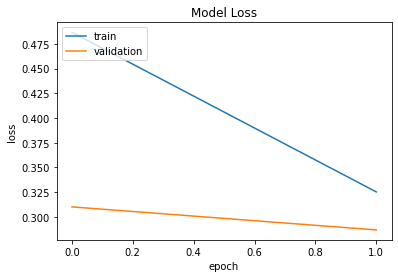

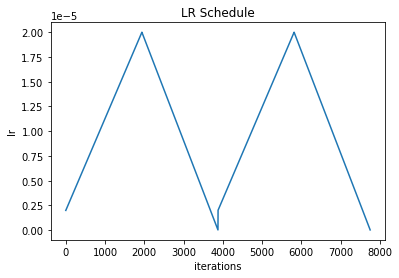

In [ ]:
#----TRAIN WITH TRIANGULAR LEARNING RATE POLICY----#


# Triangular learning rate policy has initial warmup period that increases the learning rate,
# followed by a decrease in learning rate.

history = learner.autofit(2e-5, epochs = 2) #  method employs a triangular learning rate policy

learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule

# save progress as a checkpoint
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor')

## Metrics and Evaluation


As in the case of the classical methods, several metrics will be reported, including *test accuracy, precision, recall* and *F1-score*. Each of the chosen metrics provides different insight into the performance of the models. In addition, the *confusion matrix* will be plotted to indicate the nature of the misclassifications.

1. Accuracy 

Accuracy provides a measure of how many samples are correctly predicted and is calculated as follows,

\begin{equation}
    Accuracy = \frac{(TP + TN)}{(TN + FP + FN + TP)}
\end{equation}


where $TP, TN, FP$ and $FN$ represent the number of true positives, true negatives, false positives and false negatives respectively.

2. Precision

\begin{equation}
    Precision = \frac{TP}{(TP + FP)}
\end{equation}


3. Recall

\begin{equation}
    Recall = \frac{TP}{(TP+FN)}
\end{equation}


4. F1-Score

The F1-score is the harmonic mean of the precision and recall and therefore provides a combined metric balancing these two objectives.

\begin{equation}
    F1 \; Score = \frac{(2*precision*recall)}{(precision+recall)}
\end{equation}

The F1-score provides an insightful metric in the face of class imbalance as it incorporates both precision and recall and is not skewed by the majority class.

In [ ]:
learner.validate(test, class_names=t.get_classes()) # classification report

              precision    recall  f1-score   support

        afya       0.60      0.34      0.44       157
    burudani       0.85      0.89      0.87       340
   kimataifa       0.92      0.85      0.88       300
     kitaifa       0.89      0.93      0.91      1736
     michezo       0.92      0.97      0.95       975
      uchumi       0.93      0.80      0.86       370

    accuracy                           0.90      3878
   macro avg       0.85      0.80      0.82      3878
weighted avg       0.89      0.90      0.89      3878



array([[  54,    1,    4,   97,    1,    0],
       [   4,  304,    0,   10,   22,    0],
       [   6,   21,  255,   11,    5,    2],
       [  26,   17,   15, 1617,   47,   14],
       [   0,   13,    2,    8,  947,    5],
       [   0,    1,    1,   67,    4,  297]])

It can be seen that the *afya* (health news) category has a lower f-score than the other categories due to poor recall and precision. This could be due to class imbalance as the *afya* category has much fewer training examples associated with it and thus poor representation compared to other categories. 

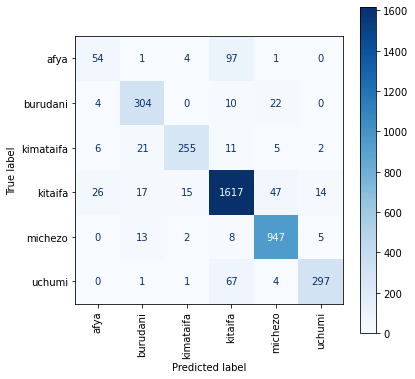

In [ ]:
cm = np.array([[  54,    1,    4,   97,    1,    0],
       [   4,  304,    0,   10,   22,    0],
       [   6,   21,  255,   11,    5,    2],
       [  26,   17,   15, 1617,   47,   14],
       [   0,   13,    2,    8,  947,    5],
       [   0,    1,    1,   67,    4,  297]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix', dpi = 300, bbox_inches='tight')
plt.show()

In [9]:
# own accuracy function

def calculate_rates(targets, predictions):

    """
    Calculates number of true positives, false positives, true negatives and false negatives for the given predictions and targets.

    Arguments:
    - True labels for the dataset
    - Predicted labels for the dataset

    Returns:
    - Number of true positives, false positives, true negatives and false negatives 
    """

    correct = 0
    


    for i in range(len(predictions)): 
        if (targets[i]==predictions[i]):
            correct += 1
    
    accuracy = correct/len(predictions)
    return accuracy
        

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('content/drive/MyDrive/News_Classification/tmp/bert_multilingual_predictor')

predictor.batch_size = 4
answer = predictor.predict(x_test) # assume this would just be the input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.8958225889633832


## Hyperparameters

#### a) Learning rate

If learning rate is too high, training loss increases due to divergence.
Therefore a learning rate of $2 \times 10^{-5}$ is chosen to ensure convergence.

#### b) Batch size

Selecting an appropriate batch size was essential to ensure that memory limitations were taken into account and thus to prevent resource exhaustion on the Google Colab platform. A batch size of 4 was found to allow for training without exceeding memory limits.

#### c) No. of epochs

Training and validation loss were monitored to identify overfitting.

#### d) Dataset size

The network was trained using half of the training dataset (7756 samples) in order to ascertain the effects of dataset size on text classification performance.

preprocessing train...
language: sw
train sequence lengths:
	mean : 331
	95percentile : 792
	99percentile : 1253


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/2
1939/1939 [==============================] - 2215s 1s/step - loss: 0.7109 - accuracy: 0.7754 - val_loss: 0.3844 - val_accuracy: 0.8767
Epoch 2/2
1939/1939 [==============================] - 2189s 1s/step - loss: 0.3736 - accuracy: 0.8871 - val_loss: 0.3188 - val_accuracy: 0.9002


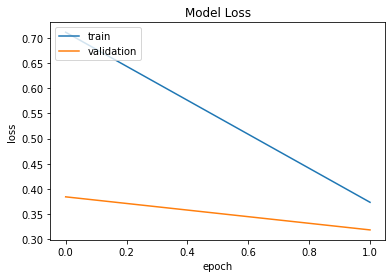

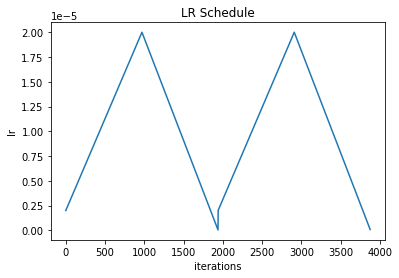

In [ ]:
MODEL_NAME = 'bert-base-multilingual-cased' # choose model
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = target_names) # create Transformer instance

# preprocess datasets - use half of the training data 
# keep validation and test sets the same for fairness
half_x = int(np.round(len(x_train)/2))
half_y = int(np.round(len(y_train)/2))
trn = t.preprocess_train(x_train[0:half_x], y_train[0:half_y])
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

# create model wrapped in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4)

# train and save model
history = learner.autofit(2e-5, epochs = 2)
learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor') # save progress as a checkpoint

We now evaluate the multilingual BERT model trained with less data and compare the results with that of the multilingual BERT model trained with all available data.

In [ ]:
#---CLASSIFICATION REPORT---#

# evaluate model on test data

learner.validate(test, class_names=t.get_classes()) 

              precision    recall  f1-score   support

        afya       0.57      0.39      0.47       157
    burudani       0.82      0.90      0.86       340
   kimataifa       0.92      0.80      0.86       300
     kitaifa       0.89      0.92      0.90      1736
     michezo       0.93      0.96      0.94       975
      uchumi       0.89      0.81      0.85       370

    accuracy                           0.89      3878
   macro avg       0.84      0.80      0.81      3878
weighted avg       0.88      0.89      0.88      3878



array([[  62,    3,    4,   88,    0,    0],
       [   3,  305,    0,   14,   18,    0],
       [   6,   20,  241,   18,   14,    1],
       [  36,   24,   14, 1594,   37,   31],
       [   0,   17,    2,   16,  937,    3],
       [   1,    1,    1,   63,    6,  298]])

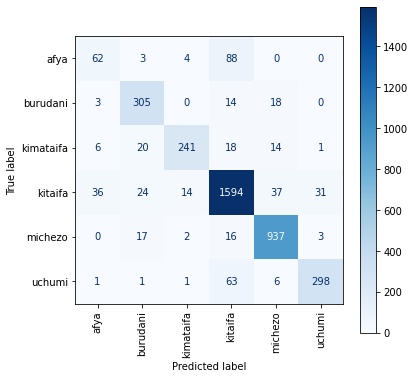

In [ ]:
cm = np.array([[  62,    3,    4,   88,    0,    0],
       [   3,  305,    0,   14,   18,    0],
       [   6,   20,  241,   18,   14,    1],
       [  36,   24,   14, 1594,   37,   31],
       [   0,   17,    2,   16,  937,    3],
       [   1,    1,    1,   63,    6,  298]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix_half_data', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
# predict and calculate accuracy

predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('./tmp/bert_multilingual_predictor') # load from checkpoint if new runtime

predictor.batch_size = 4
answer = predictor.predict(x_test) # assume this would just be the input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.8862815884476535


Very similar performance is observed in terms of both test accuracy and macro F1-score. This is an unexpected result and allows the model to train in half the time taken for training with the full dataset. However, we reset the training data back to full size for the remainder of the experiments in order to ensure parity with the other classical approaches.

## Model Optimization and Improvement

In order to improve on the baseline results, several optimization techniques will be considered.

### 1. Different Learning Rate Schedules

In order to improve the training speed of the multilingual BERT model, the *one-cycle learning rate schedule* was utilised in place of the original triangular learning rate schedule. The *one-cycle policy* allows for higher learning rates and faster convergence, known as super-convergence.


### 2. Increased No. of Epochs

The improved training speed in turn allowed for an increased number of epochs in a similar total training time. Therefore the number of epochs was doubled to 4 epochs.


preprocessing train...
language: sw
train sequence lengths:
	mean : 332
	95percentile : 786
	99percentile : 1254


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302





begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
3878/3878 [==============================] - 2236s 573ms/step - loss: 0.6006 - accuracy: 0.8127 - val_loss: 0.3589 - val_accuracy: 0.8907
Epoch 2/4
3878/3878 [==============================] - 2228s 574ms/step - loss: 0.3600 - accuracy: 0.8903 - val_loss: 0.3436 - val_accuracy: 0.8914
Epoch 3/4
3878/3878 [==============================] - 2230s 574ms/step - loss: 0.2995 - accuracy: 0.9044 - val_loss: 0.2866 - val_accuracy: 0.9116
Epoch 4/4
3878/3878 [==============================] - 2229s 574ms/step - loss: 0.2139 - accuracy: 0.9308 - val_loss: 0.2769 - val_accuracy: 0.9067


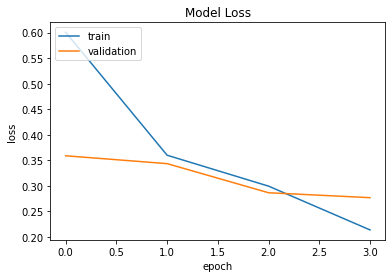

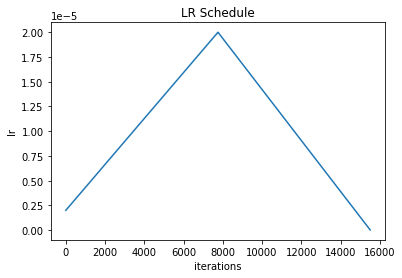

In [10]:
MODEL_NAME = 'bert-base-multilingual-cased' # choose model
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = target_names) # create Transformer instance

# preprocess datasets
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

# create model wrapped in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4)

# train and save model
history = learner.fit_onecycle(2e-5, 4)
learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor') # save progress as a checkpoint

In [11]:
learner.validate(test, class_names=t.get_classes()) 

              precision    recall  f1-score   support

        afya       0.60      0.49      0.54       157
    burudani       0.86      0.91      0.88       340
   kimataifa       0.90      0.87      0.88       300
     kitaifa       0.91      0.92      0.92      1736
     michezo       0.93      0.98      0.96       975
      uchumi       0.95      0.80      0.87       370

    accuracy                           0.90      3878
   macro avg       0.86      0.83      0.84      3878
weighted avg       0.90      0.90      0.90      3878



array([[  77,    1,   10,   68,    0,    1],
       [   0,  309,    0,   11,   20,    0],
       [   6,   18,  261,    9,    5,    1],
       [  45,   19,   18, 1599,   41,   14],
       [   0,   14,    1,    4,  956,    0],
       [   1,    0,    0,   68,    5,  296]])

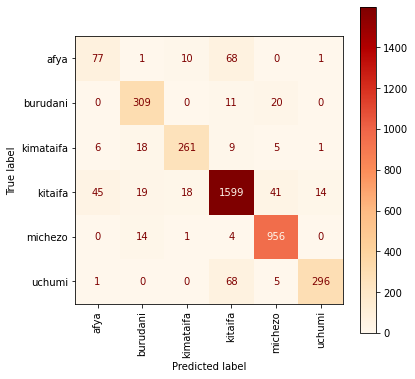

In [12]:
cm = np.array([[  77,    1,   10,   68,    0,    1],
       [   0,  309,    0,   11,   20,    0],
       [   6,   18,  261,    9,    5,    1],
       [  45,   19,   18, 1599,   41,   14],
       [   0,   14,    1,    4,  956,    0],
       [   1,    0,    0,   68,    5,  296]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap='OrRd', ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix_one_cycle', dpi = 300, bbox_inches='tight')
plt.show()

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('content/drive/MyDrive/News_Classification/tmp/bert_multilingual_predictor')

predictor.batch_size = 4
answer = predictor.predict(x_test) # assume this would just be the input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.9020113460546674


### 3. Adjusting for Class Imbalance

Similarly to the SVM, class weights can be set to emphasize under-represented classes during model training. Using the *class weight* parameter in ktrain, the class weights were set manually.

Initially, the class weights were chosen to be the ratio of the number of samples of each class to the number of
samples in the majority class, as per traditional use.

In [ ]:
# calculate number of smaples of each class in the training data

unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

['afya' 'burudani' 'kimataifa' 'kitaifa' 'michezo' 'uchumi']
[ 557 1503 1300 6797 4022 1333]



preprocessing train...
language: sw
train sequence lengths:
	mean : 332
	95percentile : 786
	99percentile : 1254


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302





begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
3878/3878 [==============================] - 4195s 1s/step - loss: 2.0030 - accuracy: 0.6842 - val_loss: 0.5741 - val_accuracy: 0.8014
Epoch 2/2
3878/3878 [==============================] - 4174s 1s/step - loss: 1.0731 - accuracy: 0.8337 - val_loss: 0.3905 - val_accuracy: 0.8672


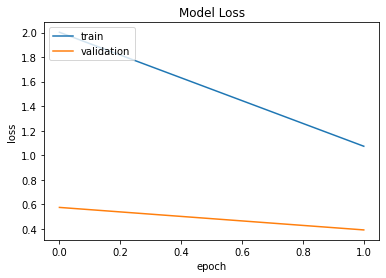

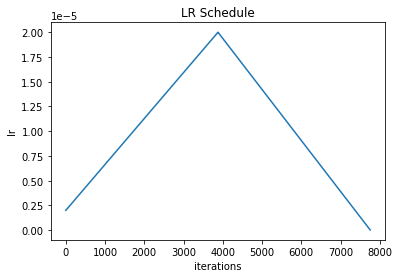

In [ ]:
# create a class weight dictionary

class_weight_dict = {0: 12.2, 1: 4.52, 2: 5.23, 3: 1, 4:1.69, 5:5.1}

MODEL_NAME = 'bert-base-multilingual-cased' # choose model
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = target_names) # create Transformer instance

# preprocess datasets
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

# create model wrapped in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4)

# train and save model
history = learner.fit_onecycle(2e-5, 2, class_weight = class_weight_dict)
learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor') # save progress as a checkpoint

In [ ]:
# evaluate model on test data

learner.validate(test, class_names=t.get_classes()) 

              precision    recall  f1-score   support

        afya       0.40      0.80      0.54       157
    burudani       0.84      0.94      0.89       340
   kimataifa       0.84      0.87      0.86       300
     kitaifa       0.95      0.78      0.85      1736
     michezo       0.94      0.97      0.95       975
      uchumi       0.74      0.90      0.82       370

    accuracy                           0.86      3878
   macro avg       0.79      0.88      0.82      3878
weighted avg       0.89      0.86      0.87      3878



array([[ 126,    1,    4,   25,    0,    1],
       [   4,  320,    0,    5,   11,    0],
       [  11,   17,  262,    4,    5,    1],
       [ 169,   24,   44, 1349,   42,  108],
       [   1,   19,    1,    6,  943,    5],
       [   1,    1,    1,   32,    1,  334]])

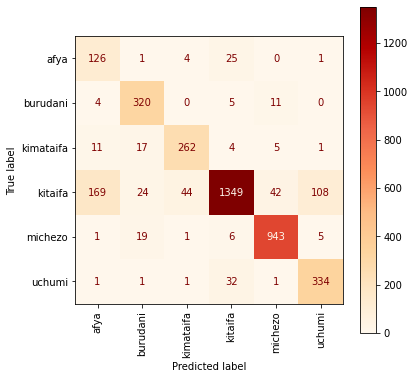

In [5]:
cm = np.array([[ 126,    1,    4,   25,    0,    1],
       [   4,  320,    0,    5,   11,    0],
       [  11,   17,  262,    4,    5,    1],
       [ 169,   24,   44, 1349,   42,  108],
       [   1,   19,    1,    6,  943,    5],
       [   1,    1,    1,   32,    1,  334]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap='OrRd', ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix_class_weights', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('content/drive/MyDrive/News_Classification/tmp/bert_multilingual_predictor')

predictor.batch_size = 4
answer = predictor.predict(x_test) # assume this would just be the input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.8597215059308922


It can be noted that the inclusion of class weights causes over-correction. Although recall is improved significantly to 88% recall, precision and accuracy have decreased. Therefore a more subtle approach to class weights is required for the BERT model.

## Combined Optimizations

In order to utilise the knowledge gained from the three optimization techniques above, we combine several of the techniques to improve performance. 

In order to provide a balance between improved recall and decreased accuracy and precision, the class weights are modified to half their original value. Additional epochs are then introduced to optimize the results.

### Modified class weights + one cycle learning rate policy + 3 epochs


preprocessing train...
language: sw
train sequence lengths:
	mean : 332
	95percentile : 786
	99percentile : 1254


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302





begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
3878/3878 [==============================] - 2250s 576ms/step - loss: 1.1793 - accuracy: 0.7789 - val_loss: 0.4588 - val_accuracy: 0.8368
Epoch 2/3
3878/3878 [==============================] - 2236s 577ms/step - loss: 0.7040 - accuracy: 0.8646 - val_loss: 0.3667 - val_accuracy: 0.8889
Epoch 3/3
3878/3878 [==============================] - 2237s 577ms/step - loss: 0.4922 - accuracy: 0.8992 - val_loss: 0.3281 - val_accuracy: 0.8832


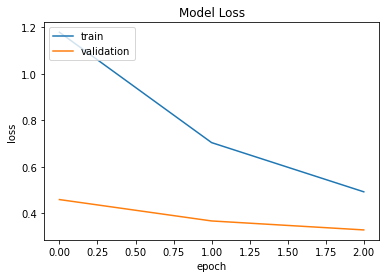

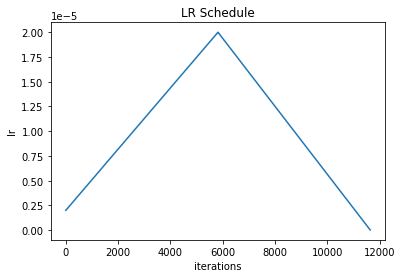

In [ ]:
# original class weights are halved in value
class_weight_dict = {0: 6.1, 1: 2.26, 2: 2.615, 3: 1, 4:1, 5:2.55}

MODEL_NAME = 'bert-base-multilingual-cased' # choose model
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = target_names) # create Transformer instance

# preprocess datasets
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

# create model wrapped in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4)

# train and save model
history = learner.fit_onecycle(2e-5, 3, class_weight = class_weight_dict)
learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor') # save progress as a checkpoint

In [ ]:
# evaluate model on test data

learner.validate(test, class_names=t.get_classes()) 

              precision    recall  f1-score   support

        afya       0.47      0.80      0.59       157
    burudani       0.86      0.94      0.90       340
   kimataifa       0.90      0.87      0.88       300
     kitaifa       0.94      0.84      0.89      1736
     michezo       0.95      0.96      0.96       975
      uchumi       0.80      0.89      0.84       370

    accuracy                           0.88      3878
   macro avg       0.82      0.88      0.84      3878
weighted avg       0.90      0.88      0.89      3878



array([[ 125,    1,    4,   26,    0,    1],
       [   2,  320,    0,    8,   10,    0],
       [  11,   16,  260,    7,    4,    2],
       [ 128,   20,   22, 1460,   30,   76],
       [   1,   15,    2,   14,  938,    5],
       [   1,    1,    1,   37,    2,  328]])

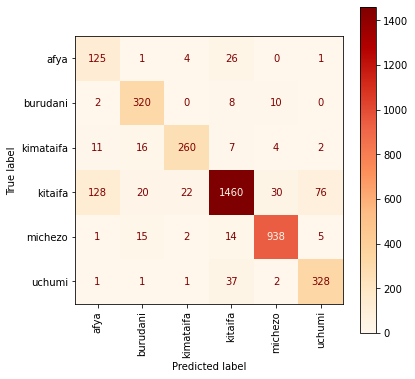

In [4]:
# plot confusion matrix

cm = np.array([[ 125,    1,    4,   26,    0,    1],
       [   2,  320,    0,    8,   10,    0],
       [  11,   16,  260,    7,    4,    2],
       [ 128,   20,   22, 1460,   30,   76],
       [   1,   15,    2,   14,  938,    5],
       [   1,    1,    1,   37,    2,  328]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap='OrRd', ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix_class_weights', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('content/drive/MyDrive/News_Classification/tmp/bert_multilingual_predictor')
predictor.batch_size = 4
answer = predictor.predict(x_test) # input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.8847343991748324


### Modified class weights + one cycle learning rate policy + 4 epochs


preprocessing train...
language: sw
train sequence lengths:
	mean : 332
	95percentile : 786
	99percentile : 1254


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 329
	95percentile : 770
	99percentile : 1234


preprocessing test...
language: sw
test sequence lengths:
	mean : 336
	95percentile : 788
	99percentile : 1302





begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
3878/3878 [==============================] - 2175s 557ms/step - loss: 1.2225 - accuracy: 0.7795 - val_loss: 0.4425 - val_accuracy: 0.8667
Epoch 2/4
3878/3878 [==============================] - 2165s 558ms/step - loss: 0.7154 - accuracy: 0.8584 - val_loss: 0.3757 - val_accuracy: 0.8925
Epoch 3/4
3878/3878 [==============================] - 2164s 558ms/step - loss: 0.6000 - accuracy: 0.8755 - val_loss: 0.3023 - val_accuracy: 0.9005
Epoch 4/4
3878/3878 [==============================] - 2164s 558ms/step - loss: 0.4205 - accuracy: 0.9109 - val_loss: 0.3139 - val_accuracy: 0.8940


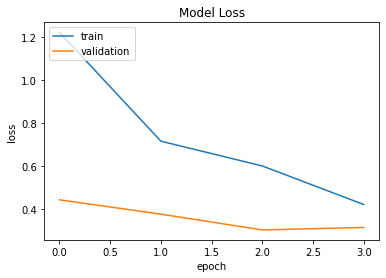

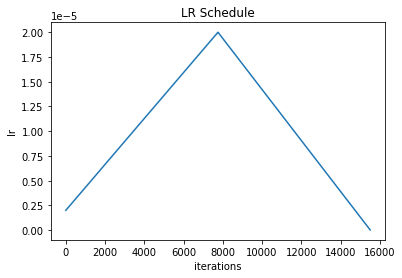

In [ ]:
class_weight_dict = {0: 6.1, 1: 2.26, 2: 2.615, 3: 1, 4:1, 5:2.55}

MODEL_NAME = 'bert-base-multilingual-cased' # choose model
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = target_names) # create Transformer instance

# preprocess datasets
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
test = t.preprocess_test(x_test, y_test)

# create model wrapped in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 4)

# train and save model
history = learner.fit_onecycle(2e-5, 4, class_weight = class_weight_dict)
learner.plot('loss') # visualising training and validation loss
learner.plot('lr') # visualise learning rate schedule
ktrain.get_predictor(learner.model, preproc = t).save('./tmp/bert_multilingual_predictor') # save progress as a checkpoint

In [ ]:
# evaluate model on test data

learner.validate(test, class_names=t.get_classes()) 

              precision    recall  f1-score   support

        afya       0.48      0.75      0.59       157
    burudani       0.86      0.94      0.90       340
   kimataifa       0.86      0.87      0.87       300
     kitaifa       0.94      0.86      0.90      1736
     michezo       0.95      0.97      0.96       975
      uchumi       0.86      0.88      0.87       370

    accuracy                           0.89      3878
   macro avg       0.83      0.88      0.85      3878
weighted avg       0.90      0.89      0.90      3878



array([[ 118,    2,    6,   30,    1,    0],
       [   2,  318,    1,    8,   11,    0],
       [  10,   16,  260,    8,    4,    2],
       [ 112,   23,   30, 1489,   34,   48],
       [   2,   10,    3,    9,  948,    3],
       [   1,    1,    1,   38,    3,  326]])

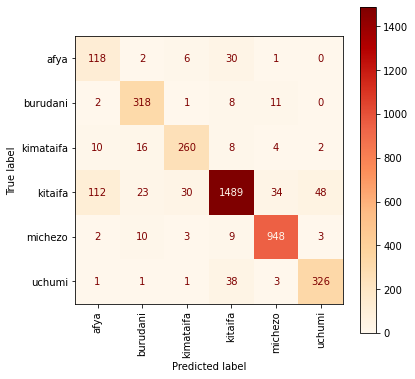

In [3]:
# plot confusion matrix

cm = np.array([[ 118,    2,    6,   30,    1,    0],
       [   2,  318,    1,    8,   11,    0],
       [  10,   16,  260,    8,    4,    2],
       [ 112,   23,   30, 1489,   34,   48],
       [   2,   10,    3,    9,  948,    3],
       [   1,    1,    1,   38,    3,  326]])


labels = ['afya', 'burudani', 'kimataifa', 'kitaifa', 'michezo', 'uchumi']

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(6, 6))
disp = disp.plot(cmap='OrRd', ax=ax, xticks_rotation='vertical')

plt.savefig('bert_confusion_matrix_class_weights', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc =t)
#predictor = ktrain.load_predictor('content/drive/MyDrive/News_Classification/tmp/bert_multilingual_predictor') # if disconnected
predictor.batch_size = 4
answer = predictor.predict(x_test) # input text
accuracy = calculate_rates(answer, y_test)
print(accuracy)

0.8919546157813306


Halving the class weights and increasing the number of epochs allows the BERT model to achieve an optimal F1-score of **85%**. Since this is an imbalanced problem, F1-score provides the best measure of classification performance. Therefore we conclude that the multlingual BERT model together with modified class weights, the one cycle learning rate schedule and four epochs obtains the best results on the Swahili News Classification dataset.

Therefore, after investigating both classical and deep learning approaches the Swahili text classification, it is observed that the multilingual BERT model attains the optimal performance with an F1-score of **85%**. Crucially, model optimizations such as accounting for class imbalance play a pivotal role in ensuring optimal model performance.